# **Facial Emotion Detection**

In [ ]:
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy
from google.colab.patches import cv2_imshow

In [ ]:
!pip install utils
!pip install livelossplot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


## Load Dataset

In [ ]:
!wget https://www.dropbox.com/s/nilt43hyl1dx82k/dataset.zip?dl=0
!unzip dataset.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
for expression in os.listdir("/content/train/"):
    print(str(len(os.listdir("/content/train/" + expression))) + " " + expression + " images")

436 disgust images
4965 neutral images
3171 surprise images
7215 happy images
4830 sad images
3995 angry images
4097 fear images


In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/content/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Build CNN

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train & Evaluate Model

In [ ]:
%%time

epochs = 45
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

# **Test Model - With Code**

In [ ]:
import cv2
import numpy as np

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
font = cv2.FONT_HERSHEY_SIMPLEX

def predictions(path):
  img = cv2.imread(path)
  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cv2_imshow(gray)
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  print(faces)
  for (x, y, w, h) in faces:
    fc = gray[y:y+h, x:x+w]
    roi = cv2.resize(fc, (48, 48))
    pred = new_model.predict(roi[np.newaxis, :, :, np.newaxis])
    stats = np.where(pred[0] == max(pred[0]))[0][0]
    return stats

def emotion_index(x):
    return {
        0: "Angry",
        1: "Disgust",
        2: "Fear",
        3: "Happy",
        4: "Neutral",
        5: "Sad",
        6: "Surprise",
    }[x]

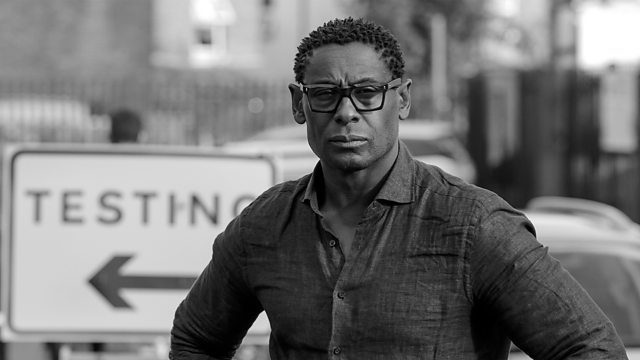

[[283  48 122 122]]


In [ ]:
path = "/content/neutral.jpg"
test_pred = emotion_index(predictions(path))

In [ ]:
test_pred

'Neutral'

## Saving Model as H5

In [ ]:
model.save('my_model.h5')
new_model = tf.keras.models.load_model('/content/my_model.h5')

## Saving Model as Directory - Use this Method for TF-Lite

In [ ]:
!mkdir -p saved_model
model.save('/content/saved_model/my_model')

INFO:tensorflow:Assets written to: /content/saved_model/my_model/assets


# Using TF-Lite

In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/saved_model/my_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('face_emotion_model.tflite', 'wb') as f:
  f.write(tflite_model)

# Run image using TF-LITE

#**Translate the following 2 sections into Flutter code!!!**

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/face_emotion_model (1).tflite")
interpreter.allocate_tensors()

#get the input tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input and output tensors.
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


# Test model on input data.
input_shape = input_details[0]['shape']


def predictions_lite(path):
  img = cv2.imread(path)
  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  for (x, y, w, h) in faces:
    fc = gray[y:y+h, x:x+w]
    roi = cv2.resize(fc, (48, 48))
    roi_axis = roi[np.newaxis, :, :, np.newaxis] #the shape is correct here
    #add the input data
    input_data = np.array(roi_axis, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = list(interpreter.get_tensor(output_details[0]['index']))
    stats = list(output_data[0]).index(max(list(output_data[0])))
    return stats

def emotion_index(x):
    return {
        0: "Angry",
        1: "Disgust",
        2: "Fear",
        3: "Happy",
        4: "Neutral",
        5: "Sad",
        6: "Surprise",
    }[x]

In [ ]:
test_pred = emotion_index(predictions_lite(path))
test_pred

'Neutral'

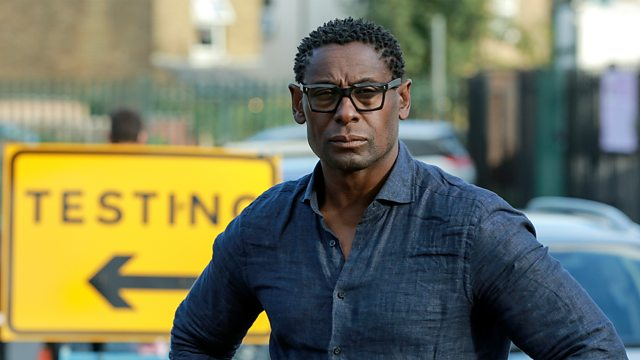

In [ ]:
path = "/content/neutral.jpg"
g = cv2.imread(path)
cv2_imshow(g)